## Anomaly Detection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import dates as md

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv')
data.shape

(15831, 2)

In [3]:
data.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text major ticklabel objects>)

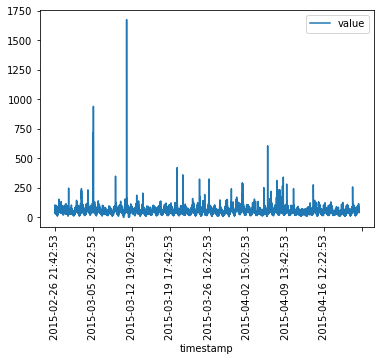

In [4]:
data.set_index('timestamp').plot()
plt.xticks(rotation='vertical')

In [5]:
data.describe()

,value
count,15831.000000
mean,53.298465
std,30.553147
min,0.000000
25%,36.000000
50%,50.000000
75%,65.000000
max,1673.000000


In [6]:
np.where(np.array(abs(data['value'] - data['value'].shift(1))) >= 400)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


(array([ 1993,  1994,  2008,  2009,  2010,  3735,  3736, 11070, 11072]),)

11070    486
11071    605
11072     60
11073     37
11074     41
Name: value, dtype: int64


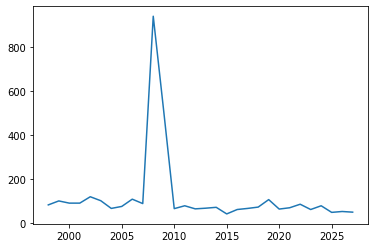

In [7]:
print(data['value'][11070:11075])
plt.plot(data['value'][2008-10:2008+20])

In [8]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = X[:int(len(X)*0.9)], X[int(len(X)*0.9):], y[:int(len(y)*0.9)], y[int(len(y)*0.9):]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14247, 1), (14247, 1), (1583, 1), (1583, 1))

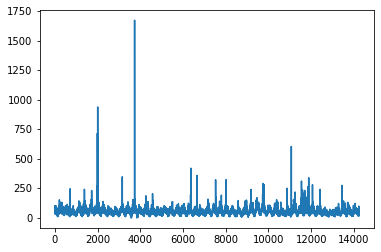

In [9]:
plt.plot(X_train)

In [10]:
# median = np.median(X_train)
# print("before", median)
# X_train[np.where(X_train >= 65)] = 65
# X_train[np.where(X_train <= 36)] = 36
# print("after", np.median(X_train))

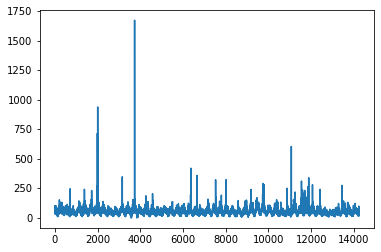

In [11]:
plt.plot(X_train)

In [12]:
n_timesteps = 144
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]
k=-5

In [13]:
print([i for i in enumerate(X_train[:500])])

[(0, array([57])), (1, array([43])), (2, array([55])), (3, array([64])), (4, array([93])), (5, array([104])), (6, array([89])), (7, array([87])), (8, array([57])), (9, array([68])), (10, array([64])), (11, array([61])), (12, array([73])), (13, array([79])), (14, array([80])), (15, array([76])), (16, array([49])), (17, array([59])), (18, array([55])), (19, array([48])), (20, array([41])), (21, array([49])), (22, array([63])), (23, array([36])), (24, array([42])), (25, array([50])), (26, array([35])), (27, array([41])), (28, array([39])), (29, array([48])), (30, array([31])), (31, array([35])), (32, array([32])), (33, array([36])), (34, array([37])), (35, array([62])), (36, array([41])), (37, array([51])), (38, array([65])), (39, array([39])), (40, array([56])), (41, array([42])), (42, array([62])), (43, array([46])), (44, array([46])), (45, array([62])), (46, array([41])), (47, array([40])), (48, array([47])), (49, array([48])), (50, array([43])), (51, array([41])), (52, array([55])), (

In [14]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples+1)]
X_train_list = X_train_list[:k]
X_train = np.concatenate(X_train_list, axis=0)
y_train_list = [np.expand_dims(y_train[i:i+5, :], axis=0) for i in range(n_timesteps, n_samples -5 + 1)]
y_train = np.concatenate(y_train_list, axis=0)
X_train = X_train[:-1, :, :]
y_train = y_train[1:, :, :]
# y_train = y_train[n_timesteps-1:, :]


X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val_list = X_val_list[:k]
X_val = np.concatenate(X_val_list, axis=0)
# y_val = y_val[n_timesteps-1:, :]
y_val_list = [np.expand_dims(y_val[i:i+5, :], axis=0) for i in range(n_timesteps, n_val_samples- 5 + 1)]
y_val = np.concatenate(y_val_list, axis=0)
X_val = X_val[:-1, :, :]
y_val = y_val[1:, :, :]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14098, 144, 1), (14098, 5, 1), (1434, 144, 1), (1434, 5, 1))

In [15]:
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
# X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
# y_val = y_val.reshape(y_val.shape[0], 1, y_val.shape[1])


In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14098, 144, 1), (14098, 5, 1), (1434, 144, 1), (1434, 5, 1))

Autoencoder with Dense layers.

In [17]:
#AUTOENCODER DENSE

def DenseAna(n_timesteps, n_features):
    i = Input(shape=(n_timesteps,1))
    # x = Dense(500, kernel_initializer='he_normal')(i)
    # x = Dropout(0.4)(x)   
    x = Dense(250, kernel_initializer='he_normal')(i)
    x = Dropout(0.4)(x)
    

    x = Dense(125, kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)

    x = Dense(125, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)

    x = Dense(250, kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)
    # x = Dense(500, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)
    x = Dense(n_features, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
    
    return model

model = DenseAna(n_timesteps, 1)

model.compile(optimizer=keras.optimizers.Adam(), loss="mae")
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 144, 1)]          0         
_________________________________________________________________
dense (Dense)                (None, 144, 250)          500       
_________________________________________________________________
dropout (Dropout)            (None, 144, 250)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 144, 125)          31375     
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 125)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 144, 125)          15750     
_________________________________________________________________
dense_3 (Dense)              (None, 144, 250)         

In [18]:
history = model.fit(
    X_train,
    X_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")],
)


Epoch 1/10
397/397 [==============================] - 2s 6ms/step - loss: 74.3009 - val_loss: 4.7749
Epoch 2/10
397/397 [==============================] - 2s 5ms/step - loss: 6.7530 - val_loss: 4.8817
Epoch 3/10
397/397 [==============================] - 2s 5ms/step - loss: 5.8557 - val_loss: 4.5661
Epoch 4/10
397/397 [==============================] - 2s 5ms/step - loss: 5.5783 - val_loss: 0.4139
Epoch 5/10
397/397 [==============================] - 2s 5ms/step - loss: 5.4829 - val_loss: 0.2436
Epoch 6/10
397/397 [==============================] - 2s 5ms/step - loss: 5.3947 - val_loss: 2.4800
Epoch 7/10
397/397 [==============================] - 2s 5ms/step - loss: 5.2923 - val_loss: 2.2158
Epoch 8/10
397/397 [==============================] - 2s 5ms/step - loss: 5.2831 - val_loss: 0.3721
Epoch 9/10
397/397 [==============================] - 2s 5ms/step - loss: 5.2586 - val_loss: 1.7545
Epoch 10/10
397/397 [==============================] - 2s 5ms/step - loss: 5.1577 - val_loss: 2.482

 The size of the input data is 250 initially, which is compressed to 125 and then later the model tries to rebuild the original input to the original size of 250. We implemented the model using (500,250), (200,100), (250,125), (100,50). The more the units in each layer, the more the loss is what we observed as a general/major trend.
Increasing the layers took much longer to run and mostly returned nan or very high loss initially.

In [20]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

(14098, 144, 1)

In [22]:
from sklearn.metrics import mean_absolute_error
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
errors = [mean_absolute_error(X_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

14098

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


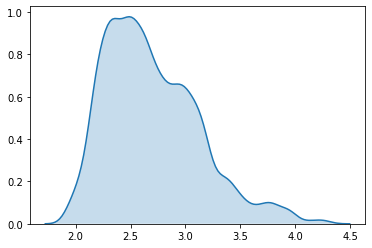

In [23]:
import seaborn as sb
sb.kdeplot(errors, shade=True)

If the errors for each value of the data set were normally distributed, we can consider all values away that are beyond 1 standard deviation from the mean as anomaly. Hence, we are now fitting this data to a normal distribution.

In [24]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(2.698128047266, 0.42946280222863586)

In [25]:
def is_anomaly(error, mean, std, threshold):
    difference = np.abs(error - mean)
    print(difference)
    value = difference / std
    if value < threshold:
        return 0
    else:
        return 1

Anomaly detection.
We get the mean and standard deviation here. We can consider all the values that lie around 1 standard deviation away from the mean. Any value beyond this can be considered an anomaly. We can consider different ranges of error beyond which a value can be anomaly. We have chosen a range of 1 standard deviation from the mean to consider a value normal.

In [ ]:

y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
val_errors = [mean_absolute_error(X_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results = [is_anomaly(x, dist.mean(), dist.std(), 1) for x in val_errors]

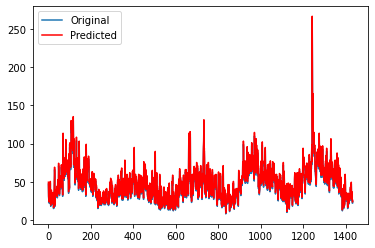

In [27]:
import matplotlib.pyplot as plt

plt.plot(X_val[:,0], label="Original")
plt.plot(y_val_pred[:,0],color="r", label="Predicted")
plt.legend()

In [28]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)

In [ ]:
plot_x=[]
plot_y=[]
for i in range(len(results)): 
  if results[i] == 1:
    plot_x.append(i)
    plot_y.append(X_val[i][0])
print(plot_x)

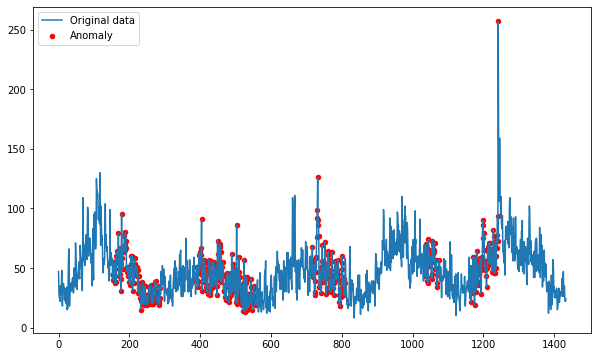

In [39]:
plt.figure(figsize=(10,6))
plt.plot(X_val[:,0].squeeze(),label='Original data')
plt.scatter(plot_x,plot_y, color="r",s=20,label='Anomaly')
plt.legend()


Plots between training and validation loss

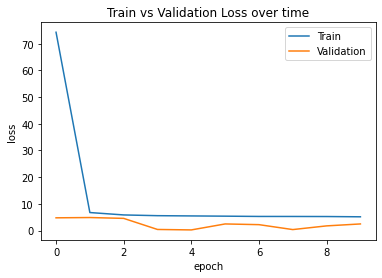

In [33]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss over time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='best')